# LeNet Lab
![LeNet Architecture](lenet.png)
Source: Yan LeCun

## Load Data

Load traffic signs data.

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import collections
import tensorflow as tf
from random import *
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
# TODO: Fill this in based on where you saved the training and testing data

training_file = './traffic-signs-data/train.p'
validation_file= './traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Visualize Data

View a sample from the dataset.

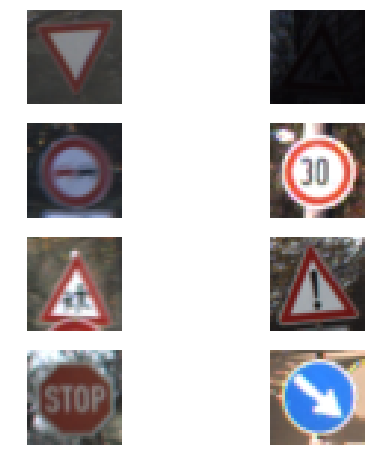

In [2]:
%matplotlib inline

num_images_to_plot = 8

def plot_images(images, nrows = 1, ncols=1):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 8))
    axs = axs.ravel()
    for index,i  in zip(range(len(images)), images):
        axs[index].imshow(images[i], plt.gray())
        axs[index].set_axis_off()

index = []
images = {}
for x in range(num_images_to_plot):
    index = randint(0, len(X_train))
    images[x] = X_train[index]
plot_images(images, 4, 2)

# Summarize and Visualize Data

In [3]:
print("Number of images in training set: "  + str(len(X_train)))
print("Number of images in validation set: "  + str(len(X_validation)))
print("Number of images in test set: " + str(len(X_test)))

Number of images in training set: 34799
Number of images in validation set: 4410
Number of images in test set: 12630


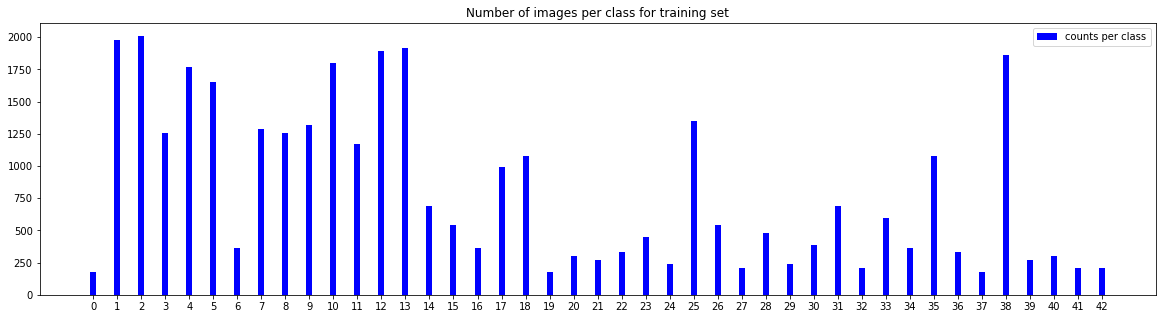

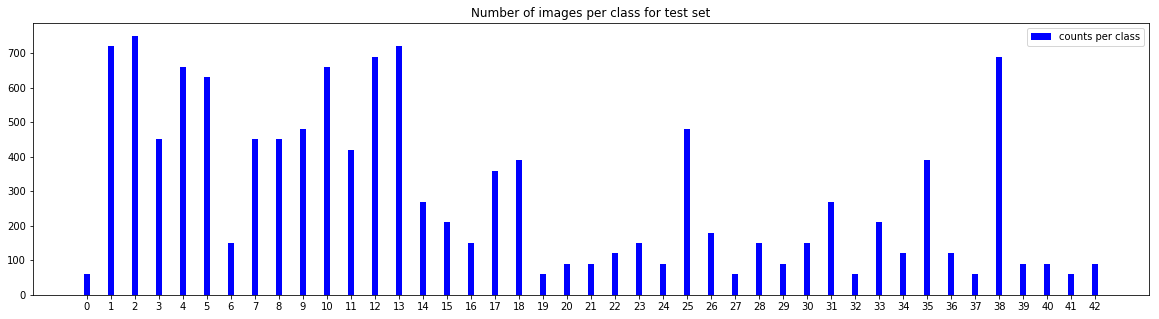

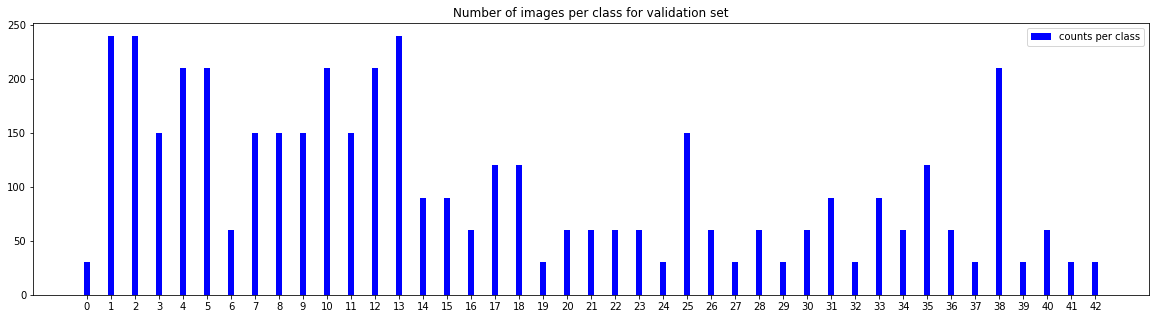

In [4]:
#plot the number of images per class
def plot_counts(labels, dataset_type):
    d = collections.Counter(labels)
    fig = plt.figure(figsize=(20, 5))
    ax = plt.subplot(1,1,1)
    ax.set_title("Number of images per class for " + dataset_type)
    ax.bar(list(d.keys()), d.values(), width=0.25,color='b',align='center', label = 'counts per class')
    ax.set_xticks(range(43))
    ax.legend()
    plt.show()
plot_counts(y_train, "training set")
plot_counts(y_test, "test set")
plot_counts(y_validation, "validation set")

## Preprocess and Augment Data

Convert and normalize grayscale and augment data for classes with fewer samples.

In [5]:
# Converting images to Grayscale.
X_tr = tf.placeholder(tf.uint8, shape = X_train.shape)
X_va = tf.placeholder(tf.uint8, shape = X_validation.shape)
X_te = tf.placeholder(tf.uint8, shape = X_test.shape)

X_train_gray = tf.image.rgb_to_grayscale(X_tr)
X_validation_gray = tf.image.rgb_to_grayscale(X_va)
X_test_gray  = tf.image.rgb_to_grayscale(X_te)

with tf.Session() as sess:
    X_train = sess.run(X_train_gray, feed_dict={X_tr:X_train})
    X_validation = sess.run(X_validation_gray, feed_dict={X_va:X_validation})
    X_test  = sess.run(X_test_gray, feed_dict={X_te:X_test})


def normalize_grayscale(image_data):
    
    a = 0.1
    b = 0.9
    
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train = normalize_grayscale(X_train)
X_validation = normalize_grayscale(X_validation)
X_test = normalize_grayscale(X_test)

Number of images in training set after augmentation: 56100


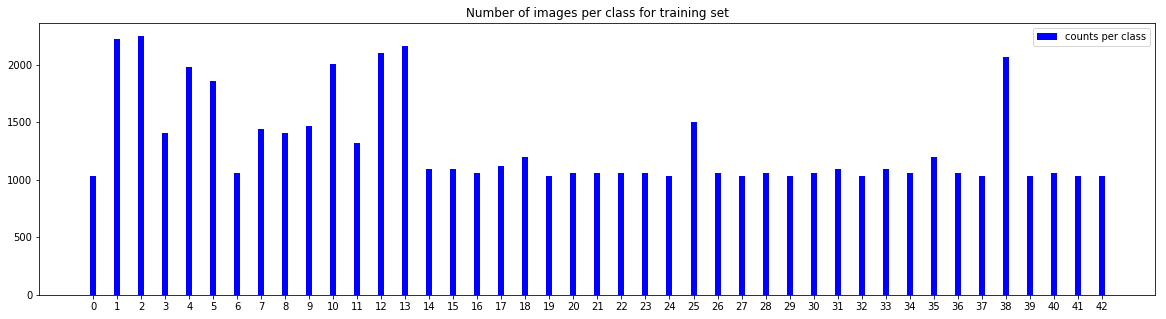

In [6]:
#Augmenting data by rotation. Add to the classes that have images below a threshold.(ie, < 1000 images in a class)

training_count = collections.Counter(y_train)
for key, value in training_count.items():
    if(value <= 1000):
        num_images_to_add = 1000 - value
        X_train_rotated = []
        Y_train_rotated = []
        X_temp = []
        random_indices = []
        indices = [i for i, x in enumerate(y_train) if x == key]
        #get all images belonging to class specified by key and augment data.
        X_temp = [X_train[i] for i in indices]
        rows = X_temp[0].shape[0]
        cols = X_temp[0].shape[1]
        for i in range(num_images_to_add):
            index = randint(0, len(X_temp) -1)
            M = cv2.getRotationMatrix2D((cols/2,rows/2),randint(-12, 12),1)
            dst = cv2.warpAffine(X_temp[index],M,(rows,cols))
            X_train_rotated.append(dst)
            Y_train_rotated.append(key)
        
        X_train_rotated = np.array(X_train_rotated)
        X_train_rotated = np.reshape(X_train_rotated, (np.shape(X_train_rotated)[0], 32, 32, 1))
        X_train = np.concatenate((X_train, X_train_rotated), axis = 0)
        Y_train_rotated = np.array(Y_train_rotated)
        y_train = np.concatenate((y_train, Y_train_rotated), axis = 0)
X_train = np.concatenate((X_train, X_validation), axis=0)
y_train = np.concatenate((y_train, y_validation), axis=0)

print("Number of images in training set after augmentation: "  + str(len(X_train)))
plot_counts(y_train, "training set")

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.

In [7]:
X_train_new, X_valid_new, y_train_new, y_valid_new = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

#shuffle the data.
X_train_new, y_train_new = shuffle(X_train_new, y_train_new)

print("Number of images in training set: "  + str(len(X_train_new)))
print("Number of images in validation set: "  + str(len(X_valid_new)))
EPOCHS = 27
BATCH_SIZE = 128

Number of images in training set: 42075
Number of images in validation set: 14025


## TODO: Implement LeNet-5
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [8]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    w_conv1 = tf.Variable(tf.truncated_normal(shape = (5,5,1,6), mean= mu, stddev = sigma))
    b_conv1 = tf.Variable(tf.zeros(6))
    conv_1 = tf.nn.conv2d(x, w_conv1, strides = [1,1,1,1], padding = 'VALID') + b_conv1

    # TODO: Activation.
    conv_1 = tf.nn.relu(conv_1)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1_maxpool =  tf.nn.max_pool(conv_1, ksize = [1,2,2,1], strides = [1,2,2,1], padding= 'VALID')

    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    w_conv2 = tf.Variable(tf.truncated_normal(shape = (5,5,6,16), mean= mu, stddev = sigma))
    b_conv2 = tf.Variable(tf.zeros(16))
    conv_2 = tf.nn.conv2d(conv1_maxpool, w_conv2, strides = [1,1,1,1], padding = 'VALID') + b_conv2

    
    # TODO: Activation.
    conv_2 = tf.nn.relu(conv_2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2_maxpool = tf.nn.max_pool(conv_2, ksize= [1,2,2,1], strides = [1,2,2,1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    
    conv2_flatten = flatten(conv2_maxpool)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 250.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (400,250), mean= mu, stddev=sigma))
    fc1_b = tf.Variable(tf.zeros(250))
    fc1_output = tf.add(tf.matmul(conv2_flatten, fc1_w), fc1_b)
    
    # TODO: Activation.
    fc2_input = tf.nn.relu(fc1_output)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (250, 84), mean= mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2_output = tf.add(tf.matmul(fc2_input, fc2_w), fc2_b)
    # TODO: Activation.
    
    fc3_input= tf.nn.dropout(tf.nn.relu(fc2_output), 0.85)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean= mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.add(tf.matmul(fc3_input, fc3_w), fc3_b)
    
    return logits

## Features and Labels
Train LeNet to classify [MNIST](http://yann.lecun.com/exdb/mnist/) data.

`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [9]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.

In [10]:
rate = 0.00097

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_new)
    validation_acc_values = []
    test_acc_values = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        #X_train_new, y_train_new = shuffle(X_train_new, y_train_new)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train_new[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_new, y_valid_new)
        validation_acc_values.append(validation_accuracy)
        
        test_accuracy = evaluate(X_test, y_test)
        test_acc_values.append(test_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Test Accuracy = {:.3f}".format(test_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")


Training...

EPOCH 1 ...
Validation Accuracy = 0.740
Test Accuracy = 0.676
EPOCH 2 ...
Validation Accuracy = 0.865
Test Accuracy = 0.787
EPOCH 3 ...
Validation Accuracy = 0.914
Test Accuracy = 0.834
EPOCH 4 ...
Validation Accuracy = 0.933
Test Accuracy = 0.859
EPOCH 5 ...
Validation Accuracy = 0.944
Test Accuracy = 0.870
EPOCH 6 ...
Validation Accuracy = 0.956
Test Accuracy = 0.879
EPOCH 7 ...
Validation Accuracy = 0.961
Test Accuracy = 0.887
EPOCH 8 ...
Validation Accuracy = 0.964
Test Accuracy = 0.886
EPOCH 9 ...
Validation Accuracy = 0.972
Test Accuracy = 0.896
EPOCH 10 ...
Validation Accuracy = 0.973
Test Accuracy = 0.895
EPOCH 11 ...
Validation Accuracy = 0.970
Test Accuracy = 0.897
EPOCH 12 ...
Validation Accuracy = 0.975
Test Accuracy = 0.897
EPOCH 13 ...
Validation Accuracy = 0.972
Test Accuracy = 0.889
EPOCH 14 ...
Validation Accuracy = 0.977
Test Accuracy = 0.898
EPOCH 15 ...
Validation Accuracy = 0.977
Test Accuracy = 0.898
EPOCH 16 ...
Validation Accuracy = 0.979
Test Accur

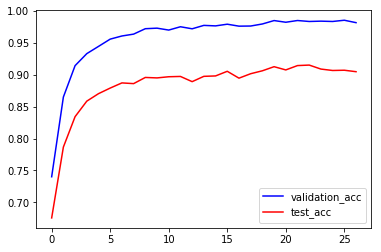

In [13]:
plt.plot(validation_acc_values, color = 'b')
plt.plot(test_acc_values, color = 'r')
plt.gca().legend(('validation_acc','test_acc'))

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

# Example Traffic Signs

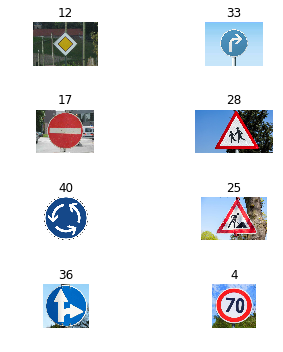

In [14]:
import glob
def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5, 5))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
            axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
        
    plt.tight_layout()


my_images= []
my_images = glob.glob('./trafficSigns/*.png')
figures = {}
labels = {}
my_signs = []
index = 0
my_labels = np.array([12, 33, 17, 28, 40, 25, 36, 4])
for my_image in my_images:
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = my_labels[index]
    index += 1
plot_figures(figures, 4, 2, labels)

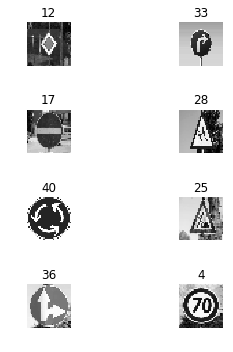

In [15]:
my_signs = np.array(my_signs)
my_signs_resize = [cv2.resize(img, (32, 32)) for img in my_signs] 
my_signs_gray = np.array([np.reshape(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (img.shape[0], img.shape[1], 1)) for img in my_signs_resize])
my_signs_normalized = normalize_grayscale(my_signs_gray)
number_to_stop = 8
figures = {}
labels = {}
for i in range(number_to_stop):
    labels[i] = my_labels[i]
    figures[i] = my_signs_normalized[i].squeeze()
    
plot_figures(figures, 4, 2, labels)

# Accuracy of new images vs test images

In [16]:
### Calculate the accuracy for the chosen images in new dataset
with tf.Session() as sess:
    saver.restore(sess, "./lenet")
    accuracy = evaluate(X_test, y_test)
    print("Accuracy with test data set = {:.2f}%".format(accuracy))
    accuracy = evaluate(my_signs_normalized, my_labels)
    print("Accuracy with new images = {:.2f}%".format(accuracy))
    #new_precision, new_recall = eval_performance(new_data, new_labels) 

Accuracy with test data set = 0.91%
Accuracy with new images = 0.62%


# Top 5 softmax probabilities

In [17]:
### Print out the top five softmax probabilities for the predictions.
k_size = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_size)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={x: my_signs_normalized})
    my_top_k = sess.run(top_k, feed_dict={x: my_signs_normalized})
    print(my_top_k)

TopKV2(values=array([[  9.78248239e-01,   2.05792785e-02,   1.13144645e-03,
          2.24425075e-05,   1.48144782e-05],
       [  9.99871731e-01,   5.90728196e-05,   5.38319837e-05,
          9.51024049e-06,   2.65687891e-06],
       [  1.00000000e+00,   4.53263297e-15,   1.30350210e-19,
          7.74259484e-24,   7.26467687e-24],
       [  9.96402144e-01,   3.58770764e-03,   7.80013033e-06,
          2.30562819e-06,   3.28009442e-08],
       [  9.11431909e-01,   8.85680765e-02,   1.24051491e-09,
          4.10118245e-10,   6.98529993e-12],
       [  9.99744952e-01,   2.52298079e-04,   2.59259150e-06,
          6.30008472e-08,   1.46363979e-08],
       [  1.00000000e+00,   8.18393747e-14,   2.02674761e-15,
          1.26944860e-15,   1.25202810e-17],
       [  7.52465487e-01,   2.41551504e-01,   5.98296849e-03,
          1.75055137e-09,   1.39477507e-09]], dtype=float32), indices=array([[25, 12,  1,  2,  5],
       [13,  7, 28, 33, 35],
       [17, 26, 37,  9, 15],
       [27, 11, 25

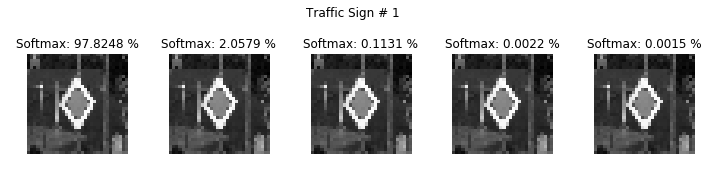

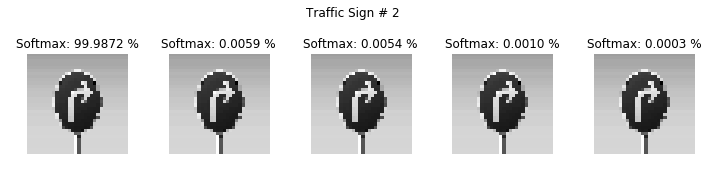

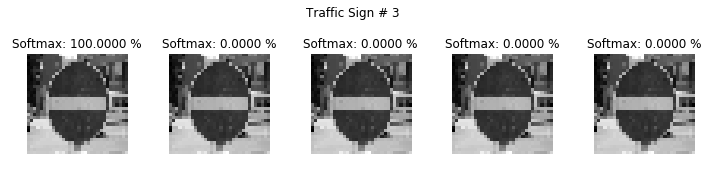

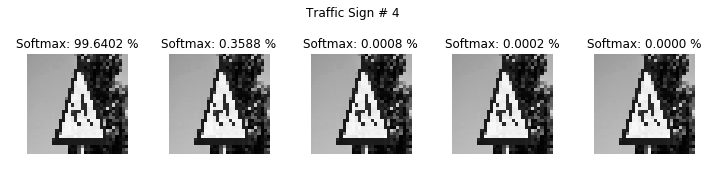

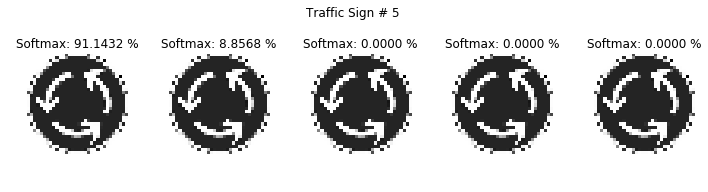

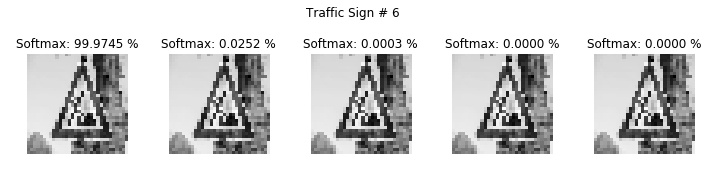

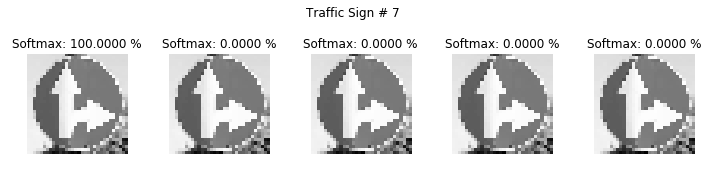

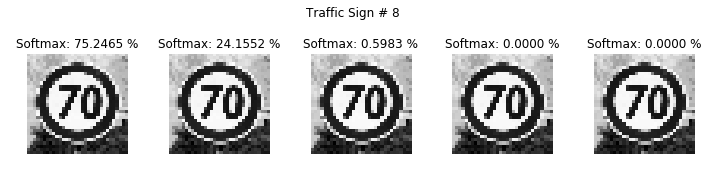

In [18]:
pred=my_top_k[1]
index = list(range(8))
for j in range(8):
    fig, ax = plt.subplots(ncols=k_size, figsize=(10, 3))
    fig.tight_layout()
    for i in range(k_size):
        image = my_signs_normalized[index[j]].squeeze()
        ax[i].imshow(image, cmap="gray")
        ax[i].set_title('Softmax: {:.4f} %'.format(my_top_k[0][j,i]*100))
        ax[i].set_xlabel('Label: '+ str(pred[j,i]))
        ax[i].axis('off')
    fig.suptitle('Traffic Sign # '+str(j+1))

# Precision Recall on test

In [19]:
def plot_precision_recall(precision, recall):
    fig = plt.figure(figsize=(20, 5))
    ax = plt.subplot(1,1,1)
    ax.set_title("Precision Recall chart for each class")
    ax.bar(num_classes-0.05, precision, width=0.25,color='b',align='center', label ='precision')
    ax.bar(num_classes+0.25, recall, width=0.25,color='r',align='center', label = 'recall')
    ax.set_xticks(range(43))
    ax.legend()
    plt.show()
    
def get_precision_and_recall(data, labels, BATCH_SIZE=1):
    num_examples=len(data)
    truepos = np.zeros(43)
    falsepos = np.zeros(43)
    falseneg = np.zeros(43)
    for offset in range(0, num_examples, BATCH_SIZE):
        with tf.Session() as sess:
            saver.restore(sess, "./lenet")
            batch_x, batch_y = data[offset:offset+BATCH_SIZE], labels[offset:offset+BATCH_SIZE]
            predicted = sess.run(tf.argmax(logits,1), feed_dict ={x: batch_x})
            actual = batch_y
            output = sess.run(tf.equal(predicted, actual))
            for i in range(len(output)):  
                if output[i]:
                    truepos[predicted[i]]+=1
                else:
                    falsepos[predicted[i]]+=1
                    falseneg[actual[i]]+=1

    # check for denominator = 0                
    precision = [truepos[i]/(truepos[i]+falsepos[i]) if (truepos[i]+falsepos[i])!=0  else 0 for i in range(len(truepos))]
    recall = [truepos[i]/(truepos[i]+falseneg[i]) if (truepos[i]+falseneg[i])!=0 else 0 for i in range(len(truepos))]
    return precision, recall

In [20]:
precision, recall = get_precision_and_recall(X_test, y_test, BATCH_SIZE)
num_classes = np.asarray([1.*i for i in range(43)])

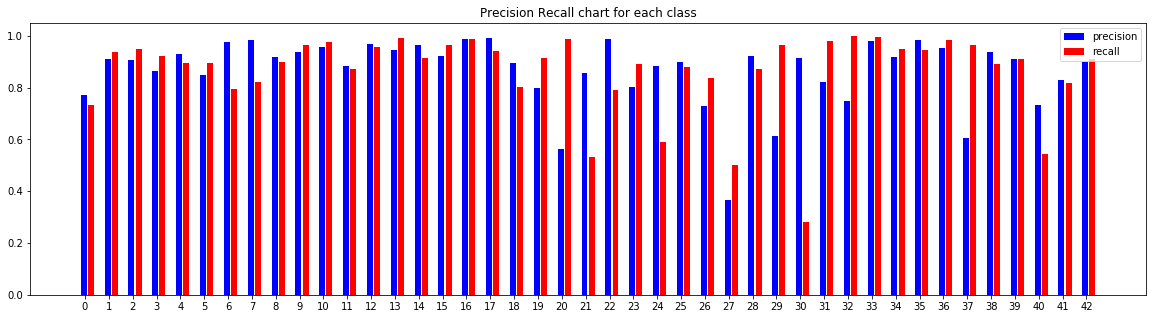

In [21]:
plot_precision_recall(precision, recall)

# Precision Recall for signs from web

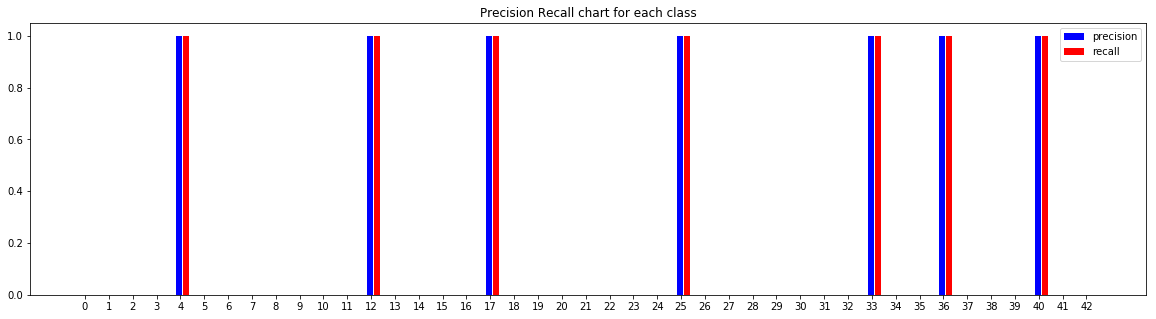

In [22]:
precision_mysigns, recall_mysigns = get_precision_and_recall(my_signs_normalized, my_labels, BATCH_SIZE)
num_classes = np.asarray([1.*i for i in range(43)])
plot_precision_recall(precision_mysigns, recall_mysigns)